In [1]:
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
from shapely.geometry import Point, Polygon
from shapely import LineString
from shapely.wkt import loads
from datetime import datetime, timedelta
from keplergl import KeplerGl
from pyproj import Proj
import pyproj
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from tqdm import tqdm
import time
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import dask_geopandas as dgpd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import glob
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from xgboost import XGBClassifier, DMatrix, predict_proba
import xgboost as xgb
from sklearn.metrics import (mean_squared_error, accuracy_score, confusion_matrix, 
                             classification_report, f1_score, roc_auc_score, roc_curve,
                             recall_score, precision_score
)
import lightgbm as lgb
import seaborn as sns
import numpy as np
import os
import optuna
import pickle
import gzip

In [2]:
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.

### Note
1. Train不能看到Test資料
2. 先測試booster哪個比較準，再往下算
3. 參數可再多增加多算

In [17]:
def plot_confusion_matrix(actual_val, pred_val, title=None):
    confusion_matrix = pd.crosstab(actual_val, pred_val,
                                   rownames=['Actual'],
                                   colnames=['Predicted'])
    
    plot = sns.heatmap(confusion_matrix, annot=True, fmt=',.0f')
    
    if title is None:
        pass
    else:
        plot.set_title(title)
        
    # plt.show()

def plot_roc_curve(model, X_test, y_test):
    """
    繪製模型的 ROC 曲線並計算 ROC AUC 分數。

    Parameters:
    - model: 已經訓練好的分類模型，例如 XGBoost。
    - X_test: 測試集的特徵。
    - y_test: 測試集的目標變數。

    Returns:
    - None
    """
    # 使用模型預測測試集概率
    y_proba = model.predict_proba(X_test)[:, 1]

    # 計算 ROC 曲線的指標
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)

    # 計算 AUC 分數
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f'ROC AUC Score: {roc_auc}')

    # 繪製 ROC 曲線
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')  # 對角線
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    # plt.show()

def concatenate_csv_files(file_paths):
    """
    合併多個 CSV 檔案成一個 DataFrame。

    Parameters:
        file_paths (list): 包含多個 CSV 檔案路徑的列表。

    Returns:
        pd.DataFrame: 合併後的 DataFrame。
    """
    # 初始化一個空的 DataFrame
    concatenated_df = pd.DataFrame()

    # 迴圈讀取每個檔案並使用 pd.concat 整合到 DataFrame
    for file_path in file_paths:
        # 使用 pd.read_csv 讀取每個檔案
        current_df = pd.read_csv(file_path)

        # 使用 pd.concat 將目前的 DataFrame 與之前的合併
        concatenated_df = pd.concat([concatenated_df, current_df], ignore_index=True)

    return concatenated_df

def concatenate_csv_files_dask(file_paths):
    """
    合併多個 CSV 檔案成一個 Dask DataFrame。

    Parameters:
        file_paths (list): 包含多個 CSV 檔案路徑的列表。

    Returns:
        dask.dataframe.DataFrame: 合併後的 Dask DataFrame。
    """
    # 初始化一個空的 Dask DataFrame
    dask_dfs = []

    # 迴圈讀取每個檔案並將數據添加到 Dask DataFrame 列表
    for file_path in file_paths:
        # 使用 dask.dataframe.read_csv 讀取每個檔案，返回一個 Dask DataFrame
        current_dask_df = dd.read_csv(file_path)
        dask_dfs.append(current_dask_df)

    # 使用 dask.dataframe.concat 將 Dask DataFrame 列表合併成一個大 Dask DataFrame
    concatenated_dask_df = dd.concat(dask_dfs, axis=0)

    return concatenated_dask_df

def under_sampling_negative_by_ratio(X_train, y_train, ratio=200000, random_state=42):
    """
    透過比例下採樣負樣本。

    Parameters:
    - ratio: 負樣本數量與正樣本數量的比例。
    - X_train: 訓練集的特徵。
    - y_train: 訓練集的目標變數。

    Returns:
    - X_train_n: 下採樣後的訓練集特徵。
    - y_train_n: 下採樣後的訓練集目標變數。
    """
    # Set negative over positive ratio
    n_p_ratio = ratio

    # Reset X index (only X have duplicated index)
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    # Find positive and negative counts
    p_train = y_train.value_counts()[1]
    n_train = y_train.value_counts()[0]

    # List negative index
    n_train_id = y_train[y_train == 0].index
    n_train_id_df = n_train_id.to_frame()

    # Random select negative index
    num = n_train - (n_p_ratio * p_train)
    n_train_id_sampled = n_train_id_df.sample(n=num, random_state=random_state)

    # transform dataframe back to index
    n_train_id_sampled_index = n_train_id_sampled.index

    # Drop selected index on X_train and y_train
    X_train_n = X_train.drop(n_train_id_sampled_index)
    y_train_n = y_train.drop(n_train_id_sampled_index)

    # Check negative over positive ratio
    p_train_new = y_train_n.value_counts()[1]
    n_train_new = y_train_n.value_counts()[0]
    n_p_ratio_new = n_train_new / p_train_new
    print(f"Positive: {p_train_new}, Negative: {n_train_new}", "\nNegative over Positive Ratio:", n_p_ratio_new)

    return X_train_n, y_train_n

### Load Datasets

In [5]:
# 儲存路徑指定
ROOT_PATH = r"D:\Chu's Document!\02 Project\06 道路塌陷防治專案(天坑)"
save_path = r"D:\Chu's Document!\02 Project\06 道路塌陷防治專案(天坑)\A Export"
FOLDER_PATH = r"D:\Chu's Document!\02 Project\06 道路塌陷防治專案(天坑)\03 Data\Model_building\TP_2021"

### Batch Loading Sinkhole Datasets

#### Filter by Specific year and month

In [7]:
# 篩選特定年月的檔案
folder_path = ROOT_PATH + r"\03 Data\Model_building\TP_2021"
years = 2021
# month = '06'
days = 7
file_pattern = folder_path + f"/Hex_TP_{days}_{years}*.csv"

# 使用 glob.glob 讀取所有符合檔名模式的檔案路徑
file_paths = glob.glob(file_pattern)
file_paths = file_paths[:26]
train_num = round(len(file_paths)*0.64)
val_num = round(len(file_paths)*0.8)
test_num = len(file_paths)
file_train = file_paths[0:train_num]
file_validation = file_paths[train_num:val_num]
file_test = file_paths[val_num:test_num]
file_test

["D:\\Chu's Document!\\02 Project\\06 道路塌陷防治專案(天坑)\\03 Data\\Model_building\\TP_2021\\Hex_TP_7_2021-06-04.csv",
 "D:\\Chu's Document!\\02 Project\\06 道路塌陷防治專案(天坑)\\03 Data\\Model_building\\TP_2021\\Hex_TP_7_2021-06-11.csv",
 "D:\\Chu's Document!\\02 Project\\06 道路塌陷防治專案(天坑)\\03 Data\\Model_building\\TP_2021\\Hex_TP_7_2021-06-18.csv",
 "D:\\Chu's Document!\\02 Project\\06 道路塌陷防治專案(天坑)\\03 Data\\Model_building\\TP_2021\\Hex_TP_7_2021-06-25.csv",
 "D:\\Chu's Document!\\02 Project\\06 道路塌陷防治專案(天坑)\\03 Data\\Model_building\\TP_2021\\Hex_TP_7_2021-07-02.csv"]

In [8]:
# 資料集切分
train_num = round(len(file_paths)*0.64)
val_num = round(len(file_paths)*0.8)
test_num = len(file_paths)

file_train = file_paths[0:train_num]
file_validation = file_paths[train_num:val_num]
file_test = file_paths[val_num:test_num]

print(f"Train: {len(file_train)}, Validation: {len(file_validation)}, Test: {len(file_test)}")

Train: 17, Validation: 4, Test: 5


In [9]:
# concatenate_csv_files
training_data = concatenate_csv_files_dask(file_train)
validation_data = concatenate_csv_files_dask(file_validation)
testing_data = concatenate_csv_files_dask(file_test)

training_data = training_data.compute()
validation_data = validation_data.compute()
testing_data = testing_data.compute()

# print shape
print("Training Data Shape:", training_data.shape, 
      "\nValidation Data Shape:", validation_data.shape,
      "\nTesting Data Shape:", testing_data.shape) #8s(大同區) #6m57s(臺北市)

Training Data Shape: (23760645, 45) 
Validation Data Shape: (5590740, 45) 
Testing Data Shape: (6988425, 45)


In [10]:
training_data.columns

Index(['Unnamed: 0', 'id', 'centroid', 'TNAME', 'soil_liquid_class', 'width',
       'road_name', 'road_id', 'sp_count', 'rp_count', 'rd_count', 'cn_count',
       'wp_count', 'pipe_count', 'geometry', 'road_case_count',
       'pipe_case_count', 'park_area', 'school_greening_area',
       'riverside_highland_area', 'birds_conservation_area',
       'agriculture_area', 'pavement_sidewalk_area',
       'pavement_parkinglot_area', 'pavement_park_area',
       'pavement_school_area', 'pavement_pac_area', 'building_floor',
       'building_area', 'building_volume', 'underground_floor',
       'underground_mrt', 'underground_hsr', 'underground_tr', 'Baseline_Date',
       'precipitation', 'earthquakes_count', 'meantidelevel',
       'meanhighwaterlevel', 'meanlowwaterlevel', 'year', 'month', 'lng',
       'lat', 'sinkhole_case_count'],
      dtype='object')

### Data Preprocessing

In [11]:
# Drop column
training_data = training_data.drop(columns=['Unnamed: 0'])
validation_data = validation_data.drop(columns=['Unnamed: 0'])
testing_data = testing_data.drop(columns=['Unnamed: 0'])

# reorder columns
new_order = [
    'id', 'centroid', 'TNAME', 'soil_liquid_class', 'width',
    'road_name', 'road_id', 'sp_count', 'rp_count', 'rd_count', 'cn_count',
    'wp_count', 'pipe_count', 'geometry', 'road_case_count',
    'pipe_case_count', 'park_area', 'school_greening_area',
    'riverside_highland_area', 'birds_conservation_area',
    'agriculture_area', 'pavement_sidewalk_area',
    'pavement_parkinglot_area', 'pavement_park_area',
    'pavement_school_area', 'pavement_pac_area', 'building_floor',
    'building_area', 'building_volume', 'underground_floor',
    'underground_mrt', 'underground_hsr', 'underground_tr', 'Baseline_Date',
    'precipitation', 'earthquakes_count', 'meantidelevel',
    'meanhighwaterlevel', 'meanlowwaterlevel', 'year', 'month', 'lng',
    'lat', 'sinkhole_case_count'
]

training_data = training_data[new_order]
validation_data = validation_data[new_order]
testing_data = testing_data[new_order]
training_data.head()

,id,centroid,TNAME,soil_liquid_class,width,road_name,road_id,sp_count,rp_count,rd_count,...,precipitation,earthquakes_count,meantidelevel,meanhighwaterlevel,meanlowwaterlevel,year,month,lng,lat,sinkhole_case_count
0,22114579,POINT (312905.37672952673 2770269.4942),南港區,0,8.0,舊莊街,A0039948,0,0,0,...,1.562,0,-0.116,1.098,-1.304,2021,1,312905.376730,2.770269e+06,0
1,22114578,POINT (312905.37672952673 2770274.4942),南港區,0,8.0,舊莊街,A0039948,0,0,0,...,1.562,0,-0.116,1.098,-1.304,2021,1,312905.376730,2.770274e+06,0
2,22114574,POINT (312905.37672952673 2770294.4942),南港區,0,6.0,無名,A0041167,0,0,0,...,1.562,0,-0.116,1.098,-1.304,2021,1,312905.376730,2.770294e+06,0
3,22109086,POINT (312901.0466025078 2770271.9942000005),南港區,0,8.0,舊莊街,A0039948,0,0,0,...,1.562,0,-0.116,1.098,-1.304,2021,1,312901.046603,2.770272e+06,0
4,22109085,POINT (312901.0466025078 2770276.9941999996),南港區,0,8.0,舊莊街,A0039948,0,0,0,...,1.562,0,-0.116,1.098,-1.304,2021,1,312901.046603,2.770277e+06,0


In [12]:
# Column Preprocess
drop_col = [
    "id", "geometry", "centroid", "sinkhole_case_count", "road_name", "road_id", 
    'Baseline_Date', 'TNAME'
]
X_train = training_data.drop(drop_col, axis=1)
X_validation = validation_data.drop(drop_col, axis=1)
X_test = testing_data.drop(drop_col, axis=1)
y_train = training_data["sinkhole_case_count"]
y_validation = validation_data["sinkhole_case_count"]
y_test = testing_data["sinkhole_case_count"]

# Ordinal Encoding
# oe = OrdinalEncoder()
# X["TNAME"] = oe.fit_transform(X[["TNAME"]])

# standard scaler
# sc= StandardScaler()
# X_train.iloc[:,0:3] = sc.fit_transform(X_train.iloc[:,0:3])
# X_test.iloc[:,0:3] = sc.transform(X_test.iloc[:,0:3])

print("X_train:")
print(X_train.head())

print("\ny_train:")
print(y_train.head())

X_train:
   soil_liquid_class  width  sp_count  rp_count  rd_count  cn_count  wp_count  \
0                  0    8.0         0         0         0         0         1   
1                  0    8.0         0         0         0         0         0   
2                  0    6.0         0         0         0         0         0   
3                  0    8.0         0         0         0         0         1   
4                  0    8.0         0         0         0         0         0   

   pipe_count  road_case_count  pipe_case_count  ...  underground_tr  \
0           1                0                0  ...               0   
1           0                0                0  ...               0   
2           0                0                0  ...               0   
3           1                0                0  ...               0   
4           0                0                0  ...               0   

   precipitation  earthquakes_count  meantidelevel  meanhighwaterlevel 

#### Export training, validatation and testing data 

In [13]:
X_train.to_csv(ROOT_PATH + r"\03 Data\Model_building\Test_TP_All\TP_2021_X_train.csv", index=False)
X_validation.to_csv(ROOT_PATH + r"\03 Data\Model_building\Test_TP_All\TP_2021_X_validation.csv", index=False)
X_test.to_csv(ROOT_PATH + r"\03 Data\Model_building\Test_TP_All\TP_2021_X_test.csv", index=False)
y_train.to_csv(ROOT_PATH + r"\03 Data\Model_building\Test_TP_All\TP_2021_y_train.csv", index=False)
y_validation.to_csv(ROOT_PATH + r"\03 Data\Model_building\Test_TP_All\TP_2021_y_validation.csv", index=False)
y_test.to_csv(ROOT_PATH + r"\03 Data\Model_building\Test_TP_All\TP_2021_y_test.csv", index=False)

### XGBoost Prediction

In [51]:
X_train = dd.read_csv(ROOT_PATH + r"\03 Data\Model_building\Test_TP_All\TP_2023_X_train.csv")
X_train = X_train.compute()
X_validation = dd.read_csv(ROOT_PATH + r"\03 Data\Model_building\Test_TP_All\TP_2023_X_validation.csv")
X_validation = X_validation.compute()
X_test = dd.read_csv(ROOT_PATH + r"\03 Data\Model_building\Test_TP_All\TP_2023_X_test.csv")
X_test = X_test.compute()
y_train = dd.read_csv(ROOT_PATH + r"\03 Data\Model_building\Test_TP_All\TP_2023_y_train.csv")
y_train = y_train.compute() 
y_train = pd.Series(y_train["sinkhole_case_count"])
y_validation = dd.read_csv(ROOT_PATH + r"\03 Data\Model_building\Test_TP_All\TP_2023_y_validation.csv")
y_validation = y_validation.compute()
y_validation = pd.Series(y_validation["sinkhole_case_count"])
y_test = dd.read_csv(ROOT_PATH + r"\03 Data\Model_building\Test_TP_All\TP_2023_y_test.csv")
y_test = y_test.compute()
y_test = pd.Series(y_test["sinkhole_case_count"]) #44s

In [52]:
# Data overview
print(f"訓練：{X_train.shape}, 驗證：{X_validation.shape}, 測試：{X_test.shape}")

# Check training data distribution
positive = y_train.value_counts()[1]
negative = y_train.value_counts()[0]
scale_pos_weight_tr = negative / positive
print(f"訓練集\nPositive: {positive}, Negative: {negative}", "\nScale Pos Weight:", scale_pos_weight_tr)

# Check validation data distribution
positive = y_validation.value_counts()[1]
negative = y_validation.value_counts()[0]
scale_pos_weight_va = negative / positive
print(f"驗證集\nPositive: {positive}, Negative: {negative}", "\nScale Pos Weight:", scale_pos_weight_va)

# Check testing data distribution
positive = y_test.value_counts()[1]
negative = y_test.value_counts()[0]
scale_pos_weight_te = negative / positive
print(f"測試集\nPositive: {positive}, Negative: {negative}", "\nScale Pos Weight:", scale_pos_weight_te)

scale_pos_weight = int(min(scale_pos_weight_tr, scale_pos_weight_va, scale_pos_weight_te))
print(scale_pos_weight)

訓練：(18169905, 19), 驗證：(4193055, 19), 測試：(5590740, 19)
訓練集
Positive: 57, Negative: 18169848 
Scale Pos Weight: 318769.2631578947
驗證集
Positive: 17, Negative: 4193038 
Scale Pos Weight: 246649.29411764705
測試集
Positive: 7, Negative: 5590733 
Scale Pos Weight: 798676.1428571428
246649


In [53]:
# Check duplicated index (if True, reset index before training)
print(f"X_train duplicated:{X_train.index.duplicated().any()}")
print(f"X_validation duplicated:{X_validation.index.duplicated().any()}")
print(f"X_test duplicated:{X_test.index.duplicated().any()}")
print(f"y_train duplicated:{y_train.index.duplicated().any()}")
print(f"y_validation duplicated:{y_validation.index.duplicated().any()}")
print(f"y_test duplicated:{y_test.index.duplicated().any()}")

X_train duplicated:True
X_validation duplicated:True
X_test duplicated:True
y_train duplicated:False
y_validation duplicated:False
y_test duplicated:False


In [54]:
# Under sampling negative by ratio (reset index will be finished inside the function)
X_train, y_train = under_sampling_negative_by_ratio(X_train, y_train, ratio=scale_pos_weight, random_state=42)
X_validation, y_validation = under_sampling_negative_by_ratio(X_validation, y_validation, ratio=scale_pos_weight, random_state=42)
X_test, y_test = under_sampling_negative_by_ratio(X_test, y_test, ratio=scale_pos_weight, random_state=42)

Positive: 57, Negative: 14058993 
Negative over Positive Ratio: 246649.0
Positive: 17, Negative: 4193033 
Negative over Positive Ratio: 246649.0
Positive: 7, Negative: 1726543 
Negative over Positive Ratio: 246649.0


#### Define optimize fuction

In [72]:
def objective_xgb(trial):
    # 將參數空間設定為優化的範圍
    params = {
        'booster': 'gbtree',
        'random_state': 42,
        'objective': 'binary:logistic',  # 二元分類問題
        'eval_metric':  'logloss', 
        'tree_method': 'hist',  # 啟用 GPU 加速
        'device': "cuda",
        # 'gpu_id': 1
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'scale_pos_weight': scale_pos_weight,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
        'max_delta_step': trial.suggest_int('max_delta_step', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'gamma': trial.suggest_int('gamma', 0, 100),
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_int('lambda', 0, 100),
        'alpha': trial.suggest_float('alpha', 0, 100),
        'eta': trial.suggest_float('eta', 0.3, 1.0),
    }
    # 使用 'objective' 參數指定損失函數
    
    # 創建 XGBoost 模型
    xgb_model_opt = XGBClassifier(**params)

    # 使用訓練資料訓練模型
    xgb_model_opt.fit(X_train, y_train)

    # 使用測試資料預測
    # y_val_pred = xgb_model_opt.predict(X_validation)
    y_train_pred = xgb_model_opt.predict(X_train)

    # 新增紀錄
    f1score_xgb = f1_score(y_train, y_train_pred)
    recall = recall_score(y_train, y_train_pred)
    accuracy = accuracy_score(y_train, y_train_pred)
    precision = precision_score(y_train, y_train_pred)
    data = {
        "Recall": recall, 
        "Precision": precision, 
        "Accuracy": accuracy,
        "F1score": f1score_xgb,
        "params": params
    }
    log.append(data)

    # 計算 F1 score 並返回
    return f1score_xgb

    # 計算 Recall 並返回
    # recall_xgb = recall_score(y_validation, y_val_pred)
    # return recall_xgb

In [77]:
# 創建 Optuna study
log = []
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

# 開始優化
study.optimize(objective_xgb, n_trials=50, n_jobs=1) # 

[I 2024-04-11 15:27:49,139] A new study created in memory with name: no-name-642afca2-c8a2-4d5d-ad64-36c7ae1e2568
[I 2024-04-11 15:28:35,831] Trial 0 finished with value: 0.000328261200421368 and parameters: {'n_estimators': 122, 'learning_rate': 0.01217426589200304, 'max_depth': 3, 'min_child_weight': 24, 'max_delta_step': 6, 'subsample': 0.7389030129790389, 'gamma': 86, 'lambda': 1, 'alpha': 25.491176399737203, 'eta': 0.46564138489967993}. Best is trial 0 with value: 0.000328261200421368.
[I 2024-04-11 15:29:27,101] Trial 1 finished with value: 0.013094417643004824 and parameters: {'n_estimators': 175, 'learning_rate': 0.07710563327802897, 'max_depth': 3, 'min_child_weight': 2, 'max_delta_step': 2, 'subsample': 0.5058160196466013, 'gamma': 93, 'lambda': 67, 'alpha': 42.81170219355591, 'eta': 0.7141908688889509}. Best is trial 1 with value: 0.013094417643004824.
[I 2024-04-11 15:30:32,357] Trial 2 finished with value: 0.003056791977261758 and parameters: {'n_estimators': 179, 'learnin

In [78]:
# Perform importance analysis
from optuna.visualization import plot_param_importances
plot_param_importances(study)

In [79]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

In [81]:
df = pd.DataFrame(log)
df.to_csv(ROOT_PATH + r"\03 Data\Model_building\XGB_50trial_log.csv", index=False)
df.head()

,Recall,Precision,Accuracy,F1score,params
0,0.964912,0.000164,0.976173,0.000328,"{'booster': 'gbtree', 'random_state': 42, 'obj..."
1,1.000000,0.006590,0.999389,0.013094,"{'booster': 'gbtree', 'random_state': 42, 'obj..."
2,1.000000,0.001531,0.997355,0.003057,"{'booster': 'gbtree', 'random_state': 42, 'obj..."
3,1.000000,0.012777,0.999687,0.025232,"{'booster': 'gbtree', 'random_state': 42, 'obj..."
4,1.000000,0.064553,0.999941,0.121277,"{'booster': 'gbtree', 'random_state': 42, 'obj..."


#### Best parameter

In [86]:
# 獲取最佳參數
best_params = study.best_params
params_fix = {
        'booster': 'gbtree',
        'random_state': 42,
        'objective': 'binary:logistic',  # 二元分類問題
        'eval_metric':  'logloss', 
        'tree_method': 'hist',  # 啟用 GPU 加速
        'device': "cuda",
    }
best_params.update(params_fix)
print("Best Parameters:", best_params)

# 使用最佳參數創建最終模型
xgb_best_model = XGBClassifier(**best_params)
xgb_best_model.fit(X_train, y_train)

# 預測
y_pred_xgbbest = xgb_best_model.predict(X_train)
# y_pred_xgbbest = xgb_best_model.predict(X_test)


Best Parameters: {'n_estimators': 196, 'learning_rate': 0.07572925368554614, 'max_depth': 7, 'min_child_weight': 71, 'max_delta_step': 1, 'subsample': 0.9676994212036928, 'gamma': 0, 'lambda': 1, 'alpha': 9.783895463498364, 'eta': 0.5731048226614238, 'booster': 'gbtree', 'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'device': 'cuda'}


In [83]:
# 計算各項指標
recall = recall_score(y_test, y_pred_xgbbest)
f1 = f1_score(y_test, y_pred_xgbbest)
accuracy = accuracy_score(y_test, y_pred_xgbbest)
precision = precision_score(y_test, y_pred_xgbbest)
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print('訓練集 Accuracy: ',xgb_best_model.score(X_train,y_train))
# print('測試集 Accuracy: ',xgb_best_model.score(X_test,y_pred_xgbbest))

c:\Users\doit\anaconda3\envs\practice_02\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Accuracy: 0.9999959456720049
F1 Score: 0.0
Recall: 0.0
Precision: 0.0
訓練集 Accuracy:  0.9999959456720049


In [38]:
# 生成分类报告
report = classification_report(y_test, y_pred_xgbbest, zero_division=1)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6988392
           1       1.00      0.00      0.00        24

    accuracy                           1.00   6988416
   macro avg       1.00      0.50      0.50   6988416
weighted avg       1.00      1.00      1.00   6988416



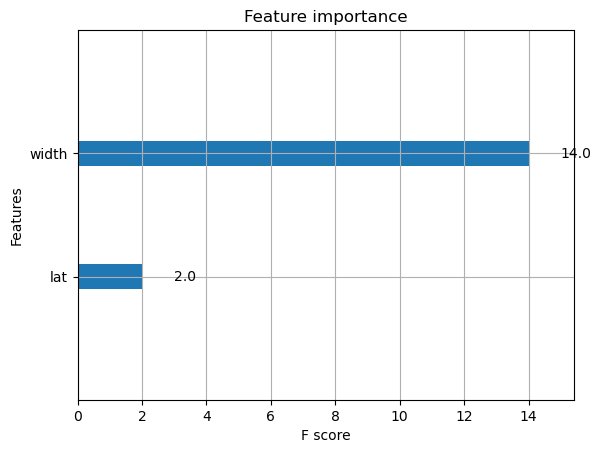

In [88]:
# 顯示樹狀結構
xgb.plot_importance(xgb_best_model)

# 儲存圖片到指定路徑
# plt.savefig(os.path.join(save_path, f"xgb_110-112_{days}days_importance.png"))
plt.show()

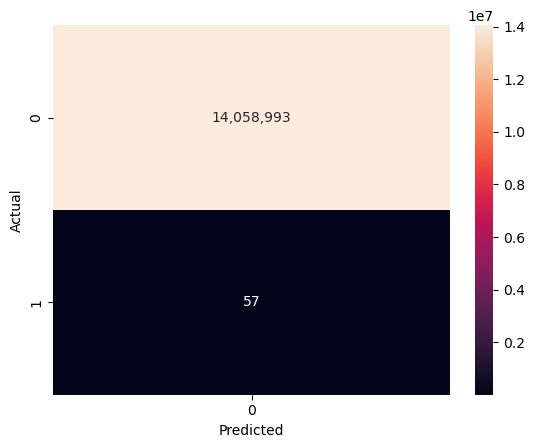

In [89]:
plot_confusion_matrix(y_train, y_pred_xgbbest)
# plot_confusion_matrix(np.squeeze(y_test), np.squeeze(y_pred_xgbbest))
# plt.savefig(os.path.join(save_path, f"xgb_110-112_{days}days_confusionmatrics.png"))
plt.show()

ROC AUC Score: 0.36948134849905384


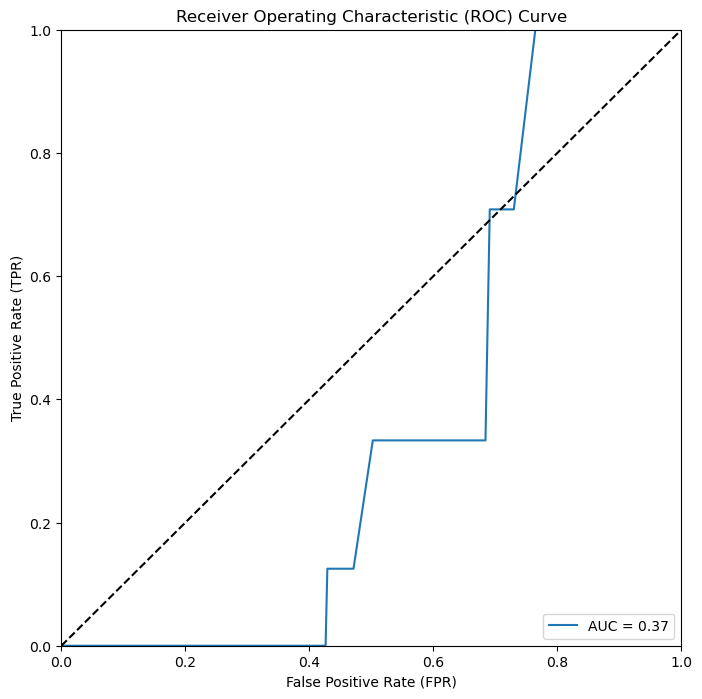

In [41]:
plot_roc_curve(xgb_best_model, X_test, y_test)
# plt.savefig(os.path.join(save_path, f"xgb_110-112_{days}days_roccurves.png"))
plt.show()

#### Check if odel overfitting

In [67]:
# 找出判定天坑的機率值
params = {
        'booster': 'gbtree',
        'random_state': 42,
        'objective': 'binary:logistic',  # 二元分類問題
        'eval_metric':  'error', 
        'tree_method': 'hist',  # 啟用 GPU 加速
        'device': "cuda",
        # 'gpu_id': 1
        'n_estimators': 150,
        'learning_rate': 0.05,
        'scale_pos_weight': scale_pos_weight,
        'max_depth': 4,
        'min_child_weight': 50,
        'max_delta_step': 5,
        'subsample': 0.5,
        'gamma': 0.3,
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': 0.9,
        'alpha': 0.1,
    }

Accuracy: 0.9991800299451243
F1 Score: 0.009792131936093455
Recall: 1.0
Precision: 0.004920155373327579


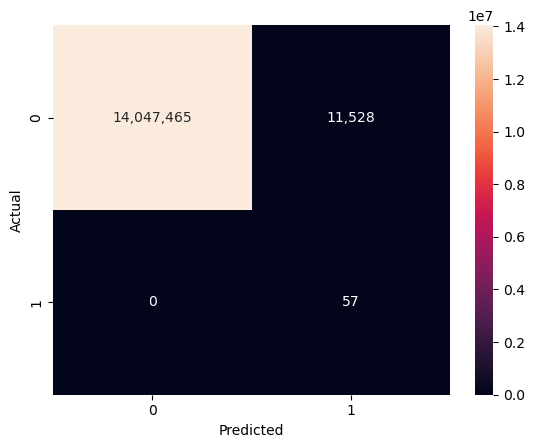

In [68]:
#  Training data

# 創建 XGBoost 模型
xgb_model_opt = XGBClassifier(**params)
# 使用訓練資料訓練模型
xgb_model_opt.fit(X_train, y_train)
pred_train = xgb_model_opt.predict(X_train)

# 計算各項指標
recall = recall_score(y_train, pred_train)
f1 = f1_score(y_train, pred_train)
accuracy = accuracy_score(y_train, pred_train)
precision = precision_score(y_train, pred_train)
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f"Recall: {recall}")
print(f"Precision: {precision}")

plot_confusion_matrix(y_train, pred_train)
plt.show()

Accuracy: 0.9991144870678862
F1 Score: 0.0
Recall: 0.0
Precision: 0.0


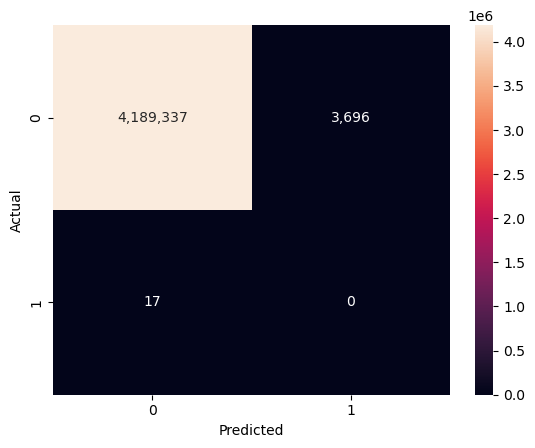

In [69]:
#  Validation data

# 創建 XGBoost 模型
# xgb_model_opt = XGBClassifier(**params)
# 使用訓練資料訓練模型
# xgb_model_opt.fit(X_validation, y_validation)
pred_val = xgb_model_opt.predict(X_validation)

# 計算各項指標
recall = recall_score(y_validation, pred_val)
f1 = f1_score(y_validation, pred_val)
accuracy = accuracy_score(y_validation, pred_val)
precision = precision_score(y_validation, pred_val)
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f"Recall: {recall}")
print(f"Precision: {precision}")

plot_confusion_matrix(y_validation, pred_val)
plt.show()

Accuracy: 0.9994179143378413
F1 Score: 0.0
Recall: 0.0
Precision: 0.0


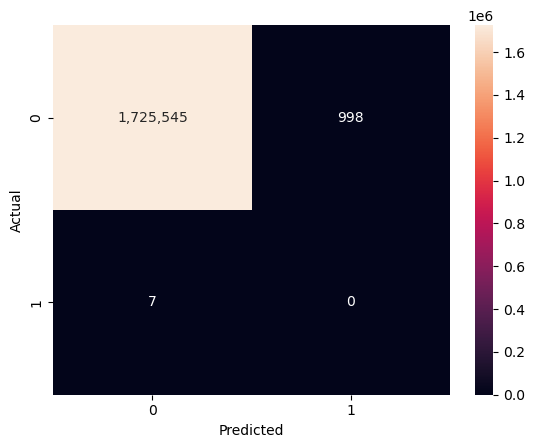

In [70]:
#  Testing data

# 創建 XGBoost 模型
# xgb_model_opt = XGBClassifier(**params)
# 使用訓練資料訓練模型
# xgb_model_opt.fit(X_test, y_test)
pred_test = xgb_model_opt.predict(X_test)

# 計算各項指標
recall = recall_score(y_test, pred_test)
f1 = f1_score(y_test, pred_test)
accuracy = accuracy_score(y_test, pred_test)
precision = precision_score(y_test, pred_test)
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f"Recall: {recall}")
print(f"Precision: {precision}")

plot_confusion_matrix(y_test, pred_test)
plt.show()

#### Find Threshold Value

In [ ]:
# 找出判定天坑的機率值
params = {
        'booster': 'gbtree',
        'random_state': 42,
        'objective': 'binary:logistic',  # 二元分類問題
        'eval_metric':  'error', 
        'tree_method': 'hist',  # 啟用 GPU 加速
        'device': "cuda",
        # 'gpu_id': 1
        'n_estimators': 150,
        'learning_rate': 0.05,
        'scale_pos_weight': scale_pos_weight,
        'max_depth': 5,
        'min_child_weight': 5,
        'max_delta_step': 5,
        'subsample': 0.5,
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': 0.5,
        'alpha': 0.5,
    }
# 使用 'objective' 參數指定損失函數

# 創建 XGBoost 模型
# xgb_model_opt = XGBClassifier(**params)
# 使用訓練資料訓練模型
# xgb_model_opt.fit(X_train, y_train)

# 將訓練集和驗證集轉換為 DMatrix 格式
dtrain = DMatrix(X_train, label=y_train)
dval = DMatrix(X_validation, label=y_validation)
dtest = DMatrix(X_test, label=y_test)
xgb_model_opt = xgb.train(params, dtrain, num_boost_round=100)
# y_val_pred = xgb_model_opt.predict(dval)

# 使用測試資料預測
# pred_train = xgb_model_opt.predict(X_train)
pred_train = xgb_model_opt.predict(dtrain)
# pred_val = xgb_model_opt.predict(dval)
# pred_test = xgb_model_opt.predict(dtest)
# proba_train = xgb_model_opt.predict_proba(dtrain)

c:\Users\doit\anaconda3\envs\practice_02\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:56:53] WARNING: D:\bld\xgboost-split_1705650090842\work\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.0061119599944436725


2024-04-11 13:36:16,024 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:54202', name: 1, status: running, memory: 0, processing: 0>
2024-04-11 13:36:16,032 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:54204', name: 3, status: running, memory: 0, processing: 0>
2024-04-11 13:36:16,043 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:54202'.
2024-04-11 13:36:16,046 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:54204'.


In [20]:
# print(pred_train)
print(pred_test)

[0.00292207 0.00292207 0.00292207 ... 0.00347233 0.00347233 0.00347233]


In [21]:
# Combine the arrays into a single array
# combined_data = np.concatenate([pred_train[:, None], proba_train], axis=1)
# combined_data = np.concatenate([pred_train[:, None]], axis=1)
combined_data = np.concatenate([pred_test[:, None]], axis=1)

# Create the DataFrame
df = pd.DataFrame(combined_data, columns=['Pred'])

print(df)

             Pred
0        0.002922
1        0.002922
2        0.002922
3        0.002922
4        0.002922
...           ...
6988411  0.003475
6988412  0.003472
6988413  0.003472
6988414  0.003472
6988415  0.003472

[6988416 rows x 1 columns]


In [22]:
# y_train_re = y_train.reset_index(drop=True)
# df['actual'] = y_train_re
# print(df)

y_val_re = y_test.reset_index(drop=True)
df['actual'] = y_val_re
print(df)

             Pred  actual
0        0.002922       0
1        0.002922       0
2        0.002922       0
3        0.002922       0
4        0.002922       0
...           ...     ...
6988411  0.003475       0
6988412  0.003472       0
6988413  0.003472       0
6988414  0.003472       0
6988415  0.003472       0

[6988416 rows x 2 columns]


In [28]:
# col = ['proba_0', 'proba_1', 'Pred', 'actual']
# df = df[col]
# df = df.sort_values(by=['actual', 'Pred'], ascending=False)

df = df.sort_values(by='actual', ascending=False)

df_1 = df[df['actual'] == 1]
df_0 = df[df['actual'] == 0]
df_threshold = df[df['Pred'] > 0.002]
print(df_threshold)

             Pred  actual
5209938  0.003793       1
5463303  0.004134       1
5209132  0.003790       1
5208330  0.003793       1
5208329  0.003761       1
...           ...     ...
6988405  0.003472       0
6988406  0.003475       0
6988407  0.003476       0
6988408  0.003472       0
6988415  0.003472       0

[6987910 rows x 2 columns]


In [29]:
# print(df['actual'].value_counts())
print(df_threshold['actual'].value_counts())

actual
0    6987886
1         24
Name: count, dtype: int64


In [30]:
df_0['Pred'].describe()

count    6.988392e+06
mean     4.671272e-03
std      7.034649e-03
min      1.687294e-03
25%      2.922166e-03
50%      3.316701e-03
75%      4.163351e-03
max      8.621386e-01
Name: Pred, dtype: float64

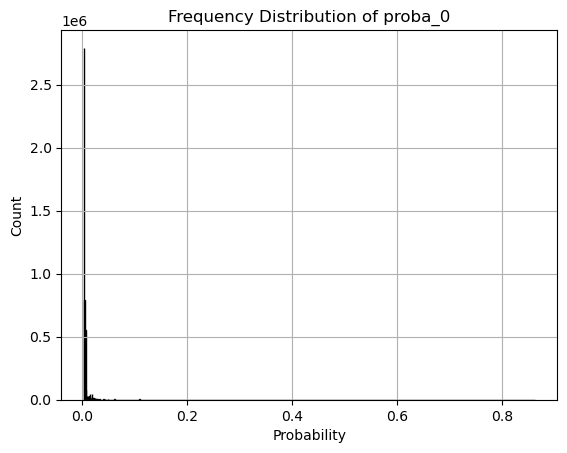

In [26]:
# Create a DataFrame and sample data

# Generate the histogram
plt.hist(df_threshold['Pred'], bins=1000, edgecolor='black',)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.title('Frequency Distribution of proba_0')
plt.grid(True)
plt.show()

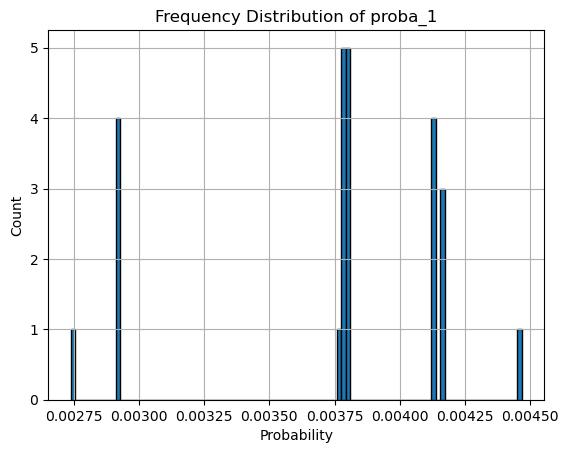

In [27]:
# Create a DataFrame and sample data

# Generate the histogram
plt.hist(df_1['Pred'], bins=100, edgecolor='black')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.title('Frequency Distribution of proba_1')
plt.grid(True)
plt.show()

#### Export Model

In [ ]:
with gzip.GzipFile(r"D:\Chu's Document!\02 Project\06 道路塌陷防治專案(天坑)\03 Data\Model_Export\xgboost-sinkhole.pgz", 'w') as f:
    pickle.dump(xgb_best_model, f)

#### Load Model

In [ ]:
with gzip.open(r"D:\Chu's Document!\02 Project\06 道路塌陷防治專案(天坑)\03 Data\Model_Export\xgboost-sinkhole.pgz", 'r') as f:
    xgb_best_model = pickle.load(f)

### LightGBM Prediction

In [6]:
from sklearn.metrics import f1_score
def objective_lgbm(trial):
    # 將參數空間設定為優化的範圍
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'random_state': 42,
        'is_unbalance': True, 
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'min_split_gain': 0.0,
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'force_row_wise': True,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'n_jobs': -1,
        'verbose': -1,
        # 'device': 'gpu',  # 啟用 GPU 加速
        # 'gpu_platform_id': 0,
        # 'gpu_device_id': 0
    }

    # 將資料拆分為訓練集和測試集
    # X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # 創建 XGBoost 模型
    lgbm_model_opt = lgb.LGBMClassifier(**params)

    # 使用訓練資料訓練模型
    lgbm_model_opt.fit(X_train, y_train)

    # 使用測試資料預測
    y_pred_opt = lgbm_model_opt.predict(X_validation)

    # 計算 F1 score 並返回
    f1score_lgbm = f1_score(y_validation, y_pred_opt)

    # 計算 Recall 並返回
    # recall_lgbm = recall_score(y_validation, y_pred_opt)

    return f1score_lgbm

In [7]:
# 創建 Optuna study
study_02 = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

# 開始優化
study_02.optimize(objective_lgbm, n_trials=10, n_jobs=4)

# 獲取最佳參數
best_params = study_02.best_params
print("Best Parameters:", best_params)

[I 2024-04-09 14:20:10,551] A new study created in memory with name: no-name-9dde113a-04c4-4d8c-afa3-77fa412d39ee


In [ ]:
params_fix = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'random_state': 42,
        'is_unbalance': True, 
        'min_split_gain': 0.0,
        'force_row_wise': True,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'n_jobs': -1,
        'verbose': -1,
        # 'device': 'gpu'  # 啟用 GPU 加速
}
best_params.update(params_fix)
print(best_params)

{'n_estimators': 137, 'learning_rate': 0.02084329048230913, 'min_data_in_leaf': 67, 'min_child_samples': 63, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'is_unbalance': True, 'min_split_gain': 0.0, 'force_row_wise': True, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'n_jobs': -1, 'verbose': -1}


In [ ]:
# 使用最佳參數創建最終模型
lgbm_best_model = lgb.LGBMClassifier(**best_params)
lgbm_best_model.fit(X_train, y_train)

# 預測
y_pred_lgbmbest = lgbm_best_model.predict(X_test)

In [ ]:
# 計算各項指標
recall = recall_score(y_test, y_pred_lgbmbest)
f1 = f1_score(y_test, y_pred_lgbmbest)
accuracy = accuracy_score(y_test, y_pred_lgbmbest)
precision = precision_score(y_test, y_pred_lgbmbest)
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print('訓練集 Accuracy: ',lgbm_best_model.score(X_train,y_train))
print('測試集 Accuracy: ',lgbm_best_model.score(X_test,y_pred_lgbmbest))

Accuracy: 0.23011747997581716
F1 Score: 3.2526165557718025e-06
Recall: 1.0
Precision: 1.6263109227688175e-06
訓練集 Accuracy:  0.23007539114816505
測試集 Accuracy:  1.0


In [ ]:
# 生成分类报告
report = classification_report(y_test, y_pred_lgbmbest, zero_division=1)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.23      0.37   5590733
           1       0.00      1.00      0.00         7

    accuracy                           0.23   5590740
   macro avg       0.50      0.62      0.19   5590740
weighted avg       1.00      0.23      0.37   5590740



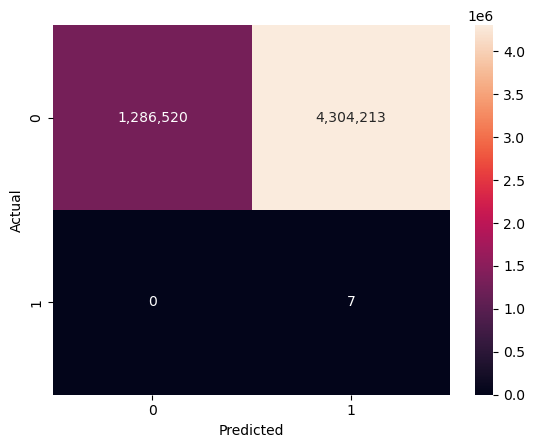

In [ ]:
plot_confusion_matrix(y_test, y_pred_lgbmbest)
# plt.savefig(os.path.join(save_path, f"lgbm_110-112_{days}days_confusionmatrics.png"))
plt.show()

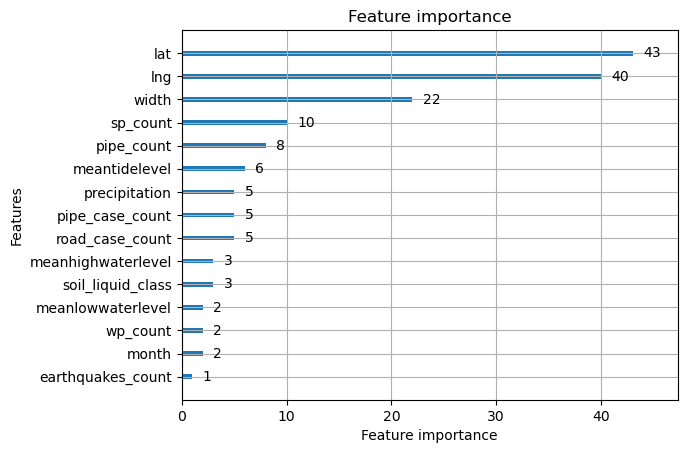

In [ ]:
# 顯示樹狀結構
lgb.plot_importance(lgbm_best_model)
# plt.savefig(os.path.join(save_path, f"lgbm_110-112_{days}days_importance.png"))
plt.show()

ROC AUC Score: 0.6150582580137525


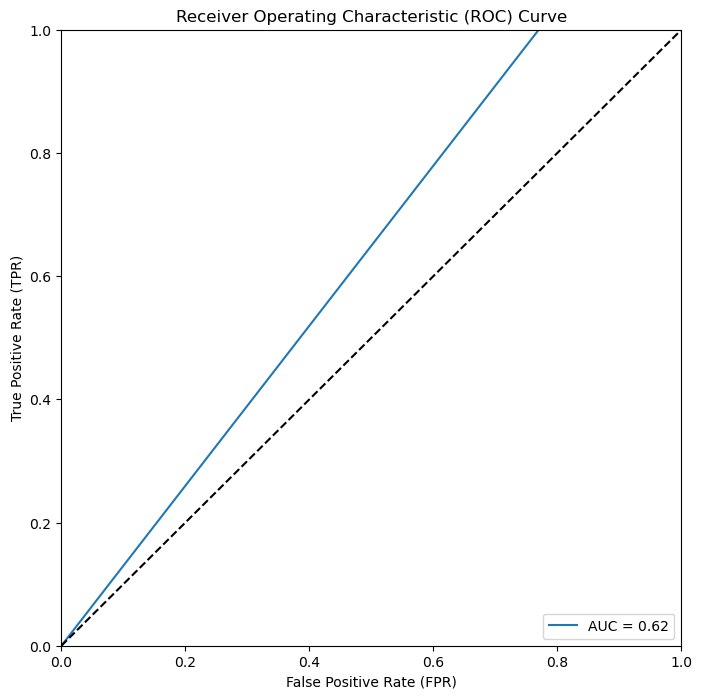

In [ ]:
plot_roc_curve(lgbm_best_model, X_test, y_test)
# plt.savefig(os.path.join(save_path, f"lgbm_110-112_{days}days_roccurves.png"))
plt.show()